In [1]:
import os
import sys
import csv
import json
import datetime
import numpy as np
import skimage.draw
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from mrcnn_defs import MaskRCNN, Config, Dataset
from mrcnn_defs import display_instances, extract_bboxes

Using TensorFlow backend.


In [2]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "rothko_cfg_coco"
	# number of classes (background + 2 classes)
	NUM_CLASSES = 1 + 2
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [3]:
# create config
cfg = PredictionConfig()

# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)

# load model weights
model.load_weights('logs/mask_rcnn_rothko_cfg_coco_0007.h5', by_name=True)

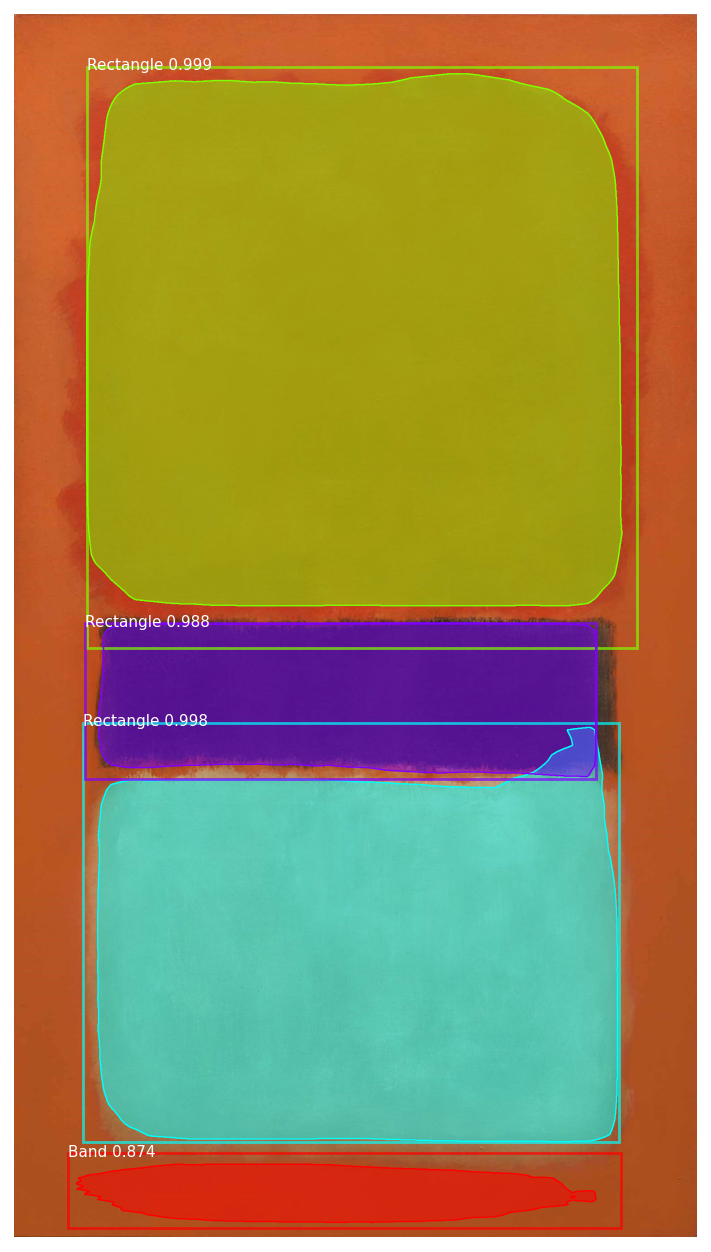

In [4]:
min_score = 0.5

path = "https://i.imgur.com/xjzo0Ex.png"
save_fig_path = './saved_img.png'

image = skimage.io.imread(path)
img_array = np.array(image)
class_names = ['BG', 'Rectangle', 'Band']
detected = model.detect([img_array])
results = detected[0]
num_shapes = len(results['class_ids'])
idxs = np.where(results['scores'] >= float(min_score))[0]
rois = results['rois'][idxs]
masks = results['masks'][:, :, idxs]
class_ids = results['class_ids'][idxs]
scores = results['scores'][idxs]
num_displayed_shapes = len(class_ids)
display_instances(img_array, results['rois'], results['masks'], results['class_ids'],
                  class_names, results['scores'], save_fig_path=save_fig_path, min_score=float(min_score))

In [4]:


def analyze_image(image_path, threshold=0.94):

    sample_img = skimage.io.imread(image_path)
    plt.imshow(sample_img)
    plt.axis('off')

    # Detect objects in the image
    detected = model.detect([sample_img])
    results = detected[0]

    # Get the number of detected shapes
    num_shapes = len(results['class_ids'])
    print("Number of detected shapes:", num_shapes)

    # Set the threshold for displayed objects and color analysis
    threshold = threshold
    print('Detection score threshold: ', threshold)

    # Get the indices of objects with scores greater than or equal to the threshold
    idxs = np.where(results['scores'] >= threshold)[0]

    # Extract the relevant results for the displayed objects
    rois = results['rois'][idxs]
    masks = results['masks'][:,:,idxs]
    class_ids = results['class_ids'][idxs]
    scores = results['scores'][idxs]

    # Count the number of displayed shapes
    num_displayed_shapes = len(class_ids)
    print("Number of displayed shapes above set threshold:", num_displayed_shapes)

    # Calculate the total number of pixels in the image
    total_pixels = sample_img.shape[0] * sample_img.shape[1]

    # Display the image with the detected shapes
    class_names = ['BG', 'Rectangle', 'Band']
    display_instances(sample_img, rois, masks, class_ids, class_names, scores)

    # Get the indices of objects with scores greater than or equal to the threshold
    idxs = np.where(results['scores'] >= threshold)[0]

    # Extract the relevant masks for the displayed objects
    masks = results.get('masks')[:,:,idxs]

    # Define a function to check if a color is bright or dull
    def is_bright(rgb):
        brightness = np.sqrt(np.dot(rgb, rgb))
        return brightness > 128

    # Extract the pixels and colors of the displayed regions
    region_pixels = []
    region_colors = []
    for i in range(masks.shape[2]):
        mask = masks[:,:,i]
        pixels = sample_img[mask]
        colors = np.mean(pixels, axis=0)
        height, width = mask.shape
        region_pixels.append(pixels)
        region_colors.append(colors)
    
        # Calculate the maximum horizontal and vertical pixels
        max_horizontal_pixels = np.max(np.sum(mask, axis=0))
        max_vertical_pixels = np.max(np.sum(mask, axis=1))
    
        # Calculate the percentage surface of the region in relation to the whole image
        region_surface = np.round((np.sum(mask) / total_pixels * 100), 1)
    
        # Loop over each region to display its color information
        for i in range(len(region_colors)):
            rgb = region_colors[i]
        if is_bright(rgb):
            brightness = "bright"
        else:
            brightness = "dull"

        # Create a figure with subplots for the color rectangle and histogram
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

        # Add the color rectangle subplot
        color_rect = np.array([colors])
        axs[0].imshow(color_rect.reshape(1, 1, 3)/255.0)
        axs[0].set_title('Average Color')
        axs[0].axis('off')

        # Add the histogram subplot
        axs[1].hist(pixels[:, 0], bins=256, color='Red', alpha=0.5, label='Red')
        axs[1].hist(pixels[:, 1], bins=256, color='Green', alpha=0.5, label='Green')
        axs[1].hist(pixels[:, 2], bins=256, color='Blue', alpha=0.5, label='Blue')
        axs[1].legend(loc='upper right')
        axs[1].set_xlim([0, 255])
        axs[1].set_xlabel('Color Value')
        axs[1].set_ylabel('Frequency')
        axs[1].set_title('Histogram')
        plt.suptitle('Region {} - Class: {} - Score: {:.2f} - Color {}: ({:.2f}, {:.2f}, {:.2f}) - Max Horizontal Pixels: {} - Max Vertical Pixels: {} - Region surface: {}%'.format(
                    i+1, class_names[results.get('class_ids')[idxs[i]]], results.get('scores')[idxs[i]], brightness,
                    region_colors[i][0], region_colors[i][1], region_colors[i][2], 
                    max_horizontal_pixels, max_vertical_pixels, region_surface))

        plt.show()



Number of detected shapes: 4
Detection score threshold:  0.85
Number of displayed shapes above set threshold: 4


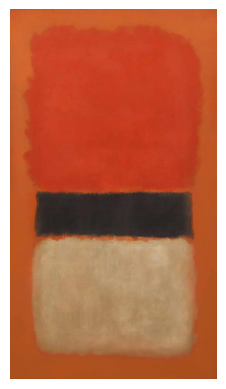

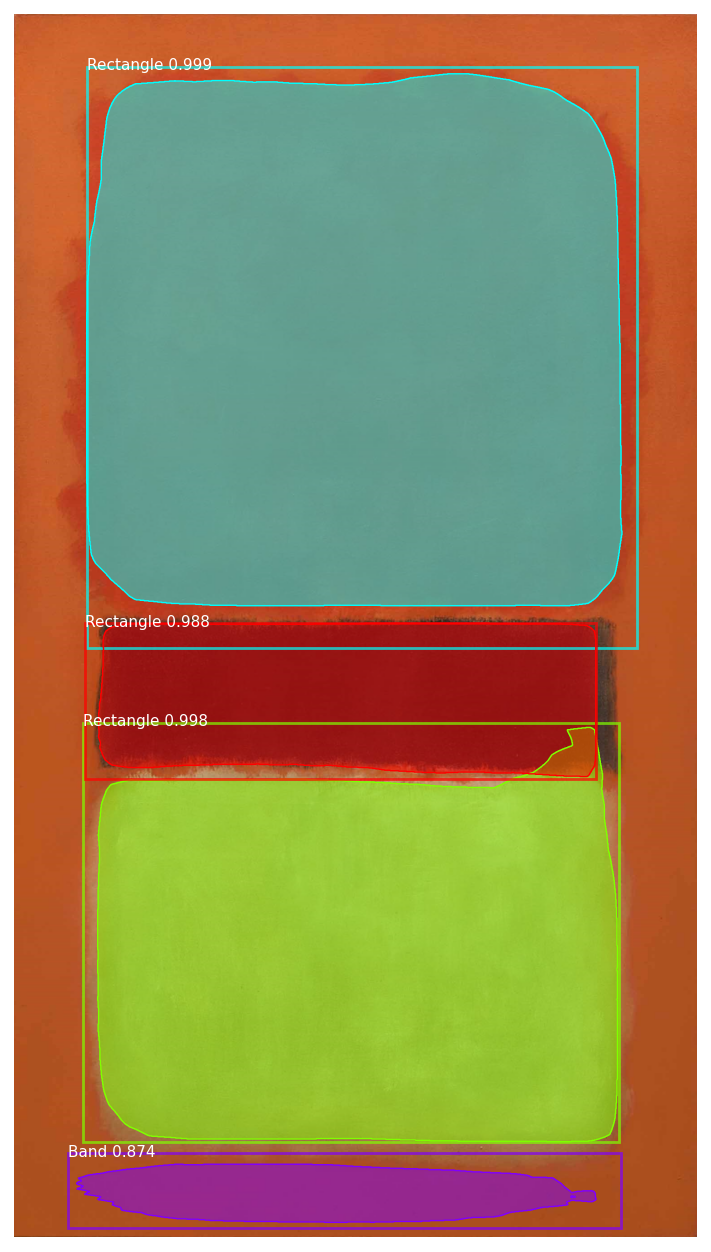

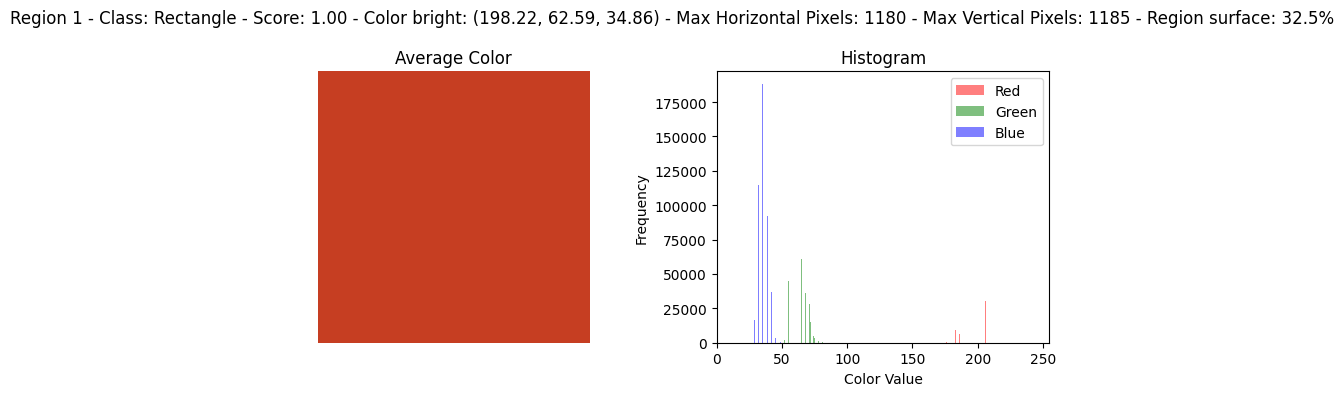

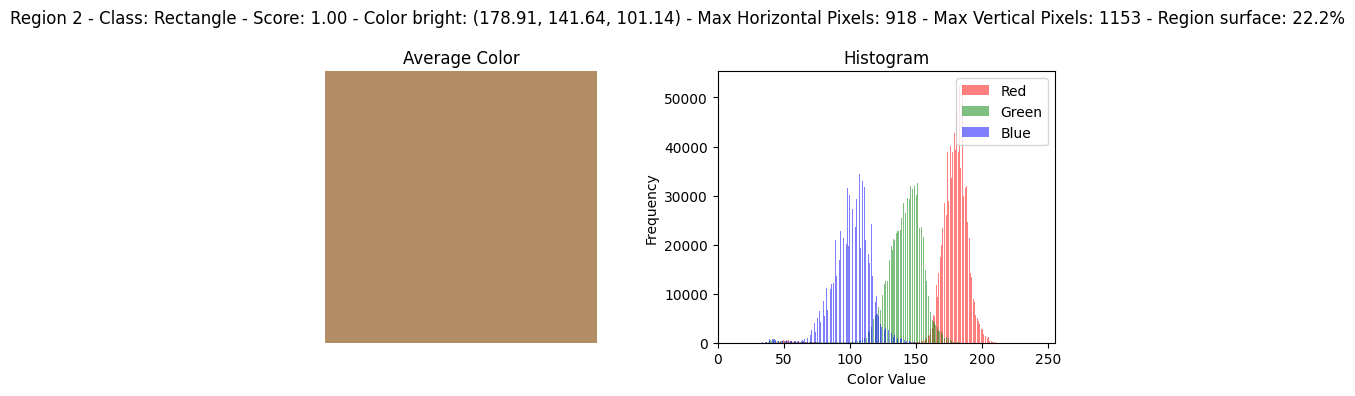

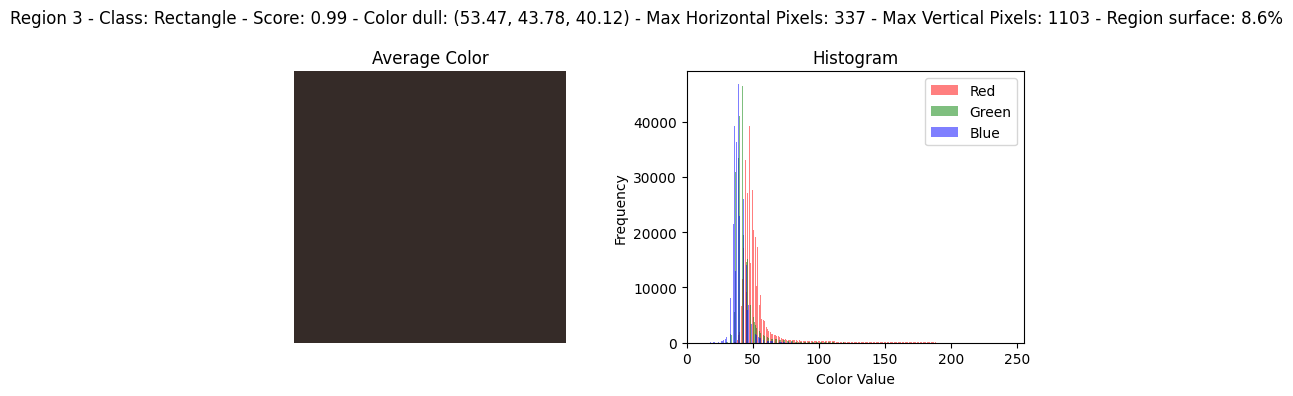

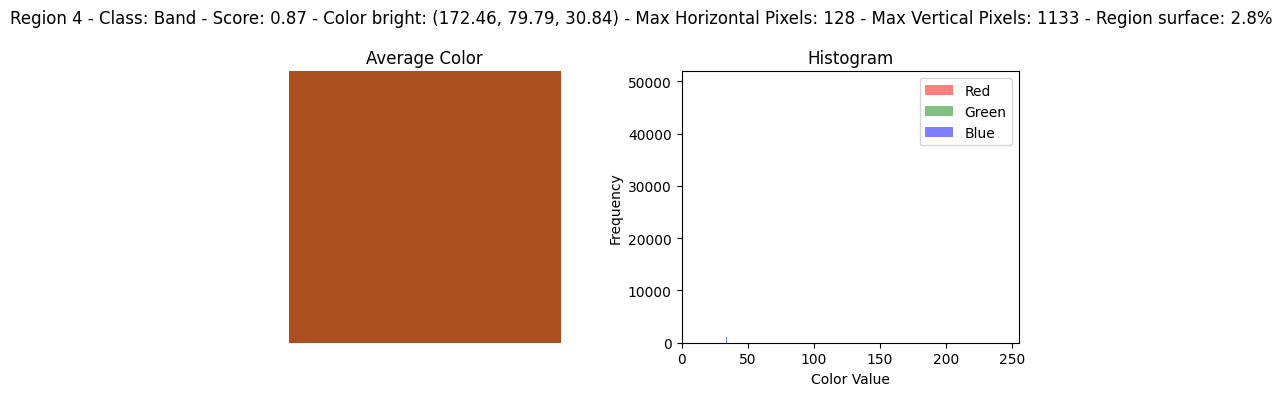

In [5]:
path = "https://i.imgur.com/xjzo0Ex.png"

analyze_image(path, threshold=0.85)

